In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
from venn import venn
import itertools

In [25]:
def read_degenotate_mk(dir_path, file_name):
    
    ## Reads Degenotate MK table into a dict
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df['standard_alpha'] = 1 - df['mk.odds.ni']
    mk_dict = df.set_index('gene').transpose().to_dict()
    return mk_dict

In [26]:
def compute_standard_MKT(p, p0, d, d0):
    
    ## calculates standard alpha and DoS
    try:
        standard_alpha = 1 - p / p0 * d0 / d
    except ZeroDivisionError:
        standard_alpha = 'NA'
    try:
        standard_dos = d / (d + d0) - p / (p + p0)
    except ZeroDivisionError:
        standard_dos = 'NA'
    return standard_alpha, standard_dos


def compute_extended_MKT(p, p0, d, d0, p_high, p0_high):
    
    ## calculates extended alpha and DoS
    try:
        ext_alpha = 1 - p_high / p0_high * d0 / d
    except ZeroDivisionError:
        ext_alpha = 'NA'
    try:
        ext_dos = d / (d + d0) - p_high / (p_high + p0_high)
    except ZeroDivisionError:
        ext_dos = 'NA'
    return ext_alpha, ext_dos


def compute_imputed_MKT(p, p0, d, d0, p_high, p0_high, p_low, p0_low):
    
    ## calculates imputed alpha and DoS
    try:
        p_wd = p_low - p_high / p0_high * p0_low
        imputed_alpha = 1 - (p - p_wd) / p0 * d0 / d
    except ZeroDivisionError:
        imputed_alpha = 'NA'
    try:
        p_wd = p_low - p_high / p0_high * p0_low
        imputed_dos = d / (d + d0) - (p - p_wd) / ((p - p_wd) + p0)
    except ZeroDivisionError:
        imputed_dos = 'NA'
    return imputed_alpha, imputed_dos

In [27]:
# dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb', 'molAte', 'agePho', 'picPub']
dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb']
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

# fig, axes = plt.subplots(3, 3, figsize=(3*5, 3*5))
# p = sns.color_palette('Paired')

all_DFs = {}
i = 0

for db in dbs:
    ## Read data for each gene with syn/nonsyn AF
    print(db)
    file_name = 'MK_test_{}_ncbi/af.gene.longest.mk.tsv'.format(db)
    mk_dict = read_degenotate_mk(dir_path, file_name)
    
    all_DFs[db] = mk_dict
    
    
    

vidMac
vidCha
indInd
anoImb


In [36]:
### Imputed MKT
cutoff = 0.15

mk_dict = all_DFs['vidMac']

for g in mk_dict:
    d  = mk_dict[g]['dN']
    d0 = mk_dict[g]['dS']
    try:
        pN_list = [float(i) for i in mk_dict[g]['af_nonsyn'].split('|')]
    except AttributeError:
        pN_list = []
    try:
        pS_list = [float(i) for i in mk_dict[g]['af_syn'].split('|')]
    except AttributeError:
        pS_list = []

    p  = len(pN_list)
    p0 = len(pS_list)

    ## calculate standard alpha and DoS
    standard_alpha, standard_dos = compute_standard_MKT(p, p0, d, d0)

    ## calculate extended alpha and DoS
    pN_af_high = [i for i in pN_list if i > cutoff - .05]
    pS_af_high = [i for i in pS_list if i < cutoff - .05]
    p_high  = len(pN_af_high)
    p0_high = len(pN_af_high)
    ext_alpha, ext_dos = compute_extended_MKT(p, p0, d, d0, p_high, p0_high)

    ## calculate imputed alpha and DoS
    pN_af_high = [i for i in pN_list if i > cutoff]
    pN_af_low  = [i for i in pN_list if i < cutoff]
    pS_af_high = [i for i in pS_list if i > cutoff]
    pS_af_low  = [i for i in pS_list if i < cutoff]
    p_high  = len(pN_af_high)
    p0_high = len(pS_af_high)
    p_low   = len(pN_af_low)
    p0_low  = len(pS_af_low)
    imputed_alpha, imputed_dos = compute_imputed_MKT(p, p0, d, d0, p_high, p0_high, p_low, p0_low)

    ## update gene dictionary with new MKT statistics 
    mk_dict[g]['standard_alpha'] = standard_alpha
    mk_dict[g]['standard_dos'] = standard_dos
    mk_dict[g]['ext_alpha'] = ext_alpha
    mk_dict[g]['ext_dos'] = ext_dos
    mk_dict[g]['imputed_alpha'] = imputed_alpha
    mk_dict[g]['imputed_dos'] = imputed_dos


In [43]:
df_mkt = pd.DataFrame.from_dict(mk_dict, orient='index')
df_mkt[df_mkt['imputed_dos']!='NA'].head()

,transcript,af_nonsyn,af_syn,pN,pS,dN,dS,mk.raw.p.value,mk.odds.ni,dos,standard_alpha,standard_dos,ext_alpha,ext_dos,imputed_alpha,imputed_dos
SMARCD3,XM_053999677.1,NaN,0.062|0.75|0.062,0.0,1.0,0.0,12.0,1.000000,NaN,0.000000,NA,0,NA,NA,NA,0
AGAP3,XM_053985072.1,0.094|0.062,0.062|0.188|0.875|0.375|0.062|0.094|0.062|0.03...,0.0,5.0,5.0,13.0,0.545306,0.000000,0.277778,0.48,0.111111,NA,NA,1,0.277778
OBSCN,XM_053972858.1,0.031|0.031|0.062|0.125|0.656|0.25|0.219|0.062...,0.125|0.094|0.25|0.031|0.062|0.125|0.188|0.156...,64.0,136.0,49.0,73.0,0.149562,0.701080,0.081639,0.0388413,0.00948248,-0.489796,-0.0983607,0.308735,0.0846995
LOC128804748,XM_053972869.1,0.031|0.375|0.125|0.062|0.156|0.062|0.031|0.09...,0.062|0.031|0.031|0.031|0.938|0.406|0.125|0.03...,5.0,4.0,7.0,8.0,1.000000,1.428571,-0.088889,-0.371429,-0.0787879,-0.142857,-0.0333333,-0.428571,-0.0888889
ACKR2,XM_053972881.1,0.375|0.031|0.312|0.938|0.031|0.531|0.031|0.06...,0.094|0.219|0.062|0.031|0.562|0.062|0.031|0.90...,9.0,4.0,9.0,12.0,0.171727,3.000000,-0.263736,-0.777778,-0.142857,-0.333333,-0.0714286,-0.666667,-0.126984


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: could not convert string to float: 'NA'

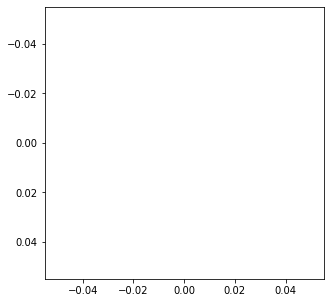

In [57]:
fig, axes = plt.subplots(figsize=(5, 5))
p = sns.color_palette('Paired')
pal = p[1], p[5]

not_na_df = df_mkt[df_mkt['dos']!='NA']

sns.scatterplot(data=not_na_df, x='standard_dos', y='imputed_dos',
                linewidth=0, s=15, color=pal[0], alpha=0.2)
sns.scatterplot(data=not_na_df, x='ext_dos', y='imputed_dos')

sns.lineplot(x=[-1, 1], y=[-1, 1], color='black', dashes=True)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)